In [90]:
import pandas as pd
import numpy as np
import seaborn as sns

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')
%pylab inline

import xgboost
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
### Подготовка данных

In [326]:
data = pd.read_csv('data.csv', sep='\t')

In [327]:
data.shape

(157573, 276)

In [328]:
tmp = ['call_date','imei8', 'report_date', 'depth', 'branch']
data = data.drop(tmp,axis=1)

In [329]:
data.head(2)

,MSISDN,target,status,subs_type,lifetime,firstcall_delay,tp_id,sim_lte_flg,segm_id,sms_out,...,bc_avg_day_mou,bc_sd_day_mou,bc_sk_day_mou,bc_kurt_day_mou,bc_avg_day_voice_cnt,bc_sd_day_voice_cnt,bc_sk_day_voice_cnt,bc_kurt_day_voice_cnt,bc_lifetime,blanc_docdate_diff
0,79081910159,0,S1,S1,4438,0,T11503,L1,S-3,?,...,"3,11800922223267","1,38693262847795","0,249152593915139","0,0379631047388643","4,43957387475131","0,844684437468782","0,0736223228566833","0,000768501135258762","2,00991650842796",-1000
1,79535041164,0,S1,S1,3022,0,T20013506,L1,S-2,?,...,"0,362406637731096","0,222795268230432","0,299634331488504","0,027128953206416","4,6792154253589","1,7346652095155","0,0343898508979378","3,31977601120327E-05","2,01224275974792",-1000


In [330]:
# Удалим константные признаки
for name in data.columns:
    n = data[name].nunique()
    if n == 1:
        data = data.drop(name,axis=1)

In [331]:
data = data.replace('?',np.NaN)

In [332]:
data['cv6'] = data['cl_sk_age']/data['cl_avg_age']
data['cv1'] = data['cl_core_size']/data['cl_tail_size']
#data['cv1'] = data['cv1'].dropna()
# data['Popularity'] = data['Popularity']
# data['Popalive'] = data['Popalive']
# data['doc_age'] 

In [333]:
data.shape

(157573, 253)

In [334]:
feat_cat = ['status','subs_type','sim_lte_flg','sms_out','cpe_type','phone_type','FLASH_CODE','calc_platform','gender',
 'R3DS','DUAL_SIM','SECOND_G','THIRD_G','FOURTH_G','CAMERA','still_first_tp','Archetype','arch_tp','is_best_device',
 'ss_serv_used','ussd_serv_used','sms_serv_used','ivr_serv_used','rbt_used_ever','rbt_using_now','internet_speed_cut_flg',
 'periodic_fee_srv_ever','periodic_fee_srv_now', 'DISPLAY_ID',
 'confcalls_srv_ever','confcalls_using_now','antiaon_using_now','anti_antiaon_using_now','bal_cont_exist',
 'tdoc','blanc_same_branch','doc_change_rf','doc_invalid','valid_mail','cust_type','macroregion','add_sim_dead_branch_cnt',
 'day_of_week','week_of_month','week_of_year','month_of_year', 'tp_id', 'tp_id','segm_id','tp_group','sales_channel',
'FORM_FACTOR', 'OS_ID', 'CPE_MANUFACTURER_NAME', 'pop', 'plc_type', 
'email_domain', 'os_version']

In [335]:
feat_numeric = ['av_dev_use', 'rc','rc_avg_day','rc_sk_day', 'cv1', 'cv6',
 'rc_kurt_day','avg_day_mou','sd_day_mou','sk_day_mou','kurt_day_mou','sd_day_voice_cnt','sk_day_voice_cnt',
 'kurt_day_voice_cnt','M1S','D1S','E1S','M4S','D4S','E4S','sum_ses_mou',
 'avg_ses_mou', 'sd_ses_mou','sk_ses_mou','kurt_ses_mou','sum_ses_mbou','avg_ses_mbou',
 'sd_ses_mbou','sk_ses_mbou','kurt_ses_mbou','avg_day_mbou','sd_day_mbou','sk_day_mbou',
 'kurt_day_mbou','avg_day_data_cnt','sd_day_data_cnt','sk_day_data_cnt','kurt_day_data_cnt',
 'cl_avg_lifetime','bal_avg_amt','bal_sd_amt','bal_sk_amt','bal_kurt_amt','bal_min_amt','bal_max_amt','be6_avg_amt',
 'add_sim_lt','add_sim_alive_avg_lt',
 'bc_bal_avg_amt', 'bc_bal_sd_amt','bc_bal_sk_amt','bc_bal_kurt_amt','bc_bal_avg_ld_days',
 'bc_bal_avg_li_days','bc_rc_avg_day','bc_rc_sd_day','bc_rc_sk_day','bc_rc_kurt_day','bc_avg_day_mou','bc_sd_day_mou',
'bc_sk_day_mou','bc_kurt_day_mou', 'bc_avg_day_voice_cnt','bc_sd_day_voice_cnt','bc_sk_day_voice_cnt','bc_kurt_day_voice_cnt',
'bc_lifetime','lifetime'  ,'start_lag' ,'cpe_m_age' ,'cpe_p_age','ret_dev_ind' ,'cpe_popularity',
'dev_park_size' ,'max_dev_use' ,'age','mou','tp_changes_cnt','io_voice_traf_ratio','sum_day_voice_cnt','avg_day_voice_cnt',
'sms_tot_cnt','mes_voice_ratio',
'out_data_ratio','tp_age','Popularity' ,'Popalive','tp_abandonement_index','b_hrs_total','b_hrs_data','blocks_total_cnt',
'blocks_data_cnt','internet_ap_blocks_cnt','cl_size','cl_onnet_cnt','cl_size_onnet_share','cl_traf_onnet_voice_share',
'cl_core_size','cl_tail_size','cl_core_out_voice_share','cl_tail_out_voice_share',
'cl_core_out_msg_share','cl_tail_out_msg_share','cl_women_share','cl_core_women_share','cl_tail_women_share','cl_opp_gender_share',
'cl_core_opp_gender_share',
'cl_tail_opp_gender_share','cl_core_avg_age','cl_tail_avg_age','cl_avg_age','cl_sd_age','cl_sk_age','cl_branches_count',
'cl_smartphones_share','days_home_cnt' ,'locs_cnt','bal_avg_ld_days','bal_avg_li_days' ,'be_ok_cnt','be7_total_cnt','be3_tot_cnt','be6_tot_cnt',
'be11_tot_cnt','content_total_cnt' ,'content_days_cnt','SMS_900_cnt' ,'SMS_900_days','SMS_109_cnt',
'SMS_109_days','SMS_3116_cnt','SMS_3116_days','SMS_1946_cnt','SMS_1946_days', 'out_data_ratio',
'SMS_OKru_cnt','SMS_OKru_days','SMS_312_cnt','SMS_312_days' ,'SMS_396_cnt','SMS_396_days','SMS_679_cnt','SMS_679_days',
'SMS_1595_cnt','SMS_1595_days','SMS_681_cnt',
'SMS_681_days','SMS_2317_cnt','SMS_2317_days','SMS_145_cnt','SMS_145_days','SMS_32665_cnt','SMS_32665_days',
'SMS_1023_cnt','SMS_1023_days','SMS_2420_cnt','SMS_2420_days','SMS_9000_cnt','SMS_9000_days','add_sim_cnt',
'add_sim_alive_cnt','add_sim_dead_cnt','add_sim_branch_cnt','add_sim_alive_branch_cnt','add_sim_dead_branch_cnt', 
'firstcall_delay','be_ok_amt','be7_tot_amt','be3_tot_amt','be3_avg_amt','be6_tot_amt','be11_tot_amt','be11_avg_amt',
'content_total_amt','add_sim_dead_avg_lt', 'blanc_docdate_diff', 'out_data_ratio', 'days_with_data_trafic', 'last_flash',
'doc_age', 'SMS_OKru_cnt','M2S','D2S','E2S','M3S','D3S' ,'E3S' ,'R2VS','R3VS','R5VS','sgc_2g_vs','sgc_3g_vs','R2DS','R5DS',
'sgc_2g_ds','sgc_3g_ds','sgc_4g_ds'
]

In [336]:
# преобразовать в object
def str_to_obj(x):
    data[x] = data[x].astype(object)

In [337]:
# преобразовать во float
for i in feat_numeric:
    if (data[i].dtypes != 'int64') & (data[i].dtypes != 'float'):
        data[i] = data[i].str.replace(",",".").astype(float)

In [338]:
for i in feat_cat:
    str_to_obj(i)

In [339]:
data.head()

,MSISDN,target,status,subs_type,lifetime,firstcall_delay,tp_id,sim_lte_flg,segm_id,sms_out,...,bc_sk_day_mou,bc_kurt_day_mou,bc_avg_day_voice_cnt,bc_sd_day_voice_cnt,bc_sk_day_voice_cnt,bc_kurt_day_voice_cnt,bc_lifetime,blanc_docdate_diff,cv6,cv1
0,79081910159,0,S1,S1,4438,0,T11503,L1,S-3,NaN,...,0.249153,0.037963,4.439574,0.844684,0.073622,0.000769,2.009917,-1000,0.00000,0.108696
1,79535041164,0,S1,S1,3022,0,T20013506,L1,S-2,NaN,...,0.299634,0.027129,4.679215,1.734665,0.034390,0.000033,2.012243,-1000,0.02381,0.300000
2,79514782745,0,S1,S1,3228,0,T10009470,L0,S-3,NaN,...,0.415765,0.068287,0.967529,0.183408,0.027991,-0.003353,1.686411,-1000,0.00000,0.387097
3,79081993277,1,S1,S1,4385,0,T1957,L0,S-3,NaN,...,0.749464,0.204917,0.028471,0.021820,0.182148,0.003022,1.985913,-1000,0.00000,0.000000
4,79504428118,0,S1,S1,4510,0,T30001908,L1,S-2,S0,...,0.545379,0.097713,0.604091,0.133534,0.080558,0.001319,1.997950,0,0.00000,0.240000


In [340]:
tmp_1 = ['cl_size','cl_onnet_cnt','cl_size_onnet_share','cl_traf_onnet_voice_share','cl_core_size','cl_tail_size', 'cv1', 'cv6']

In [341]:
tmp_2 = ['cl_core_out_voice_share','cl_tail_out_voice_share','cl_core_out_msg_share','cl_tail_out_msg_share','cl_women_share',
'cl_core_women_share']

In [342]:
tmp_3 = ['cl_tail_women_share','cl_opp_gender_share', 'cl_core_opp_gender_share','cl_tail_opp_gender_share','cl_core_avg_age']

In [343]:
tmp_4 = ['cl_tail_avg_age','cl_avg_age','cl_sd_age','cl_sk_age','cl_branches_count','cl_smartphones_share']

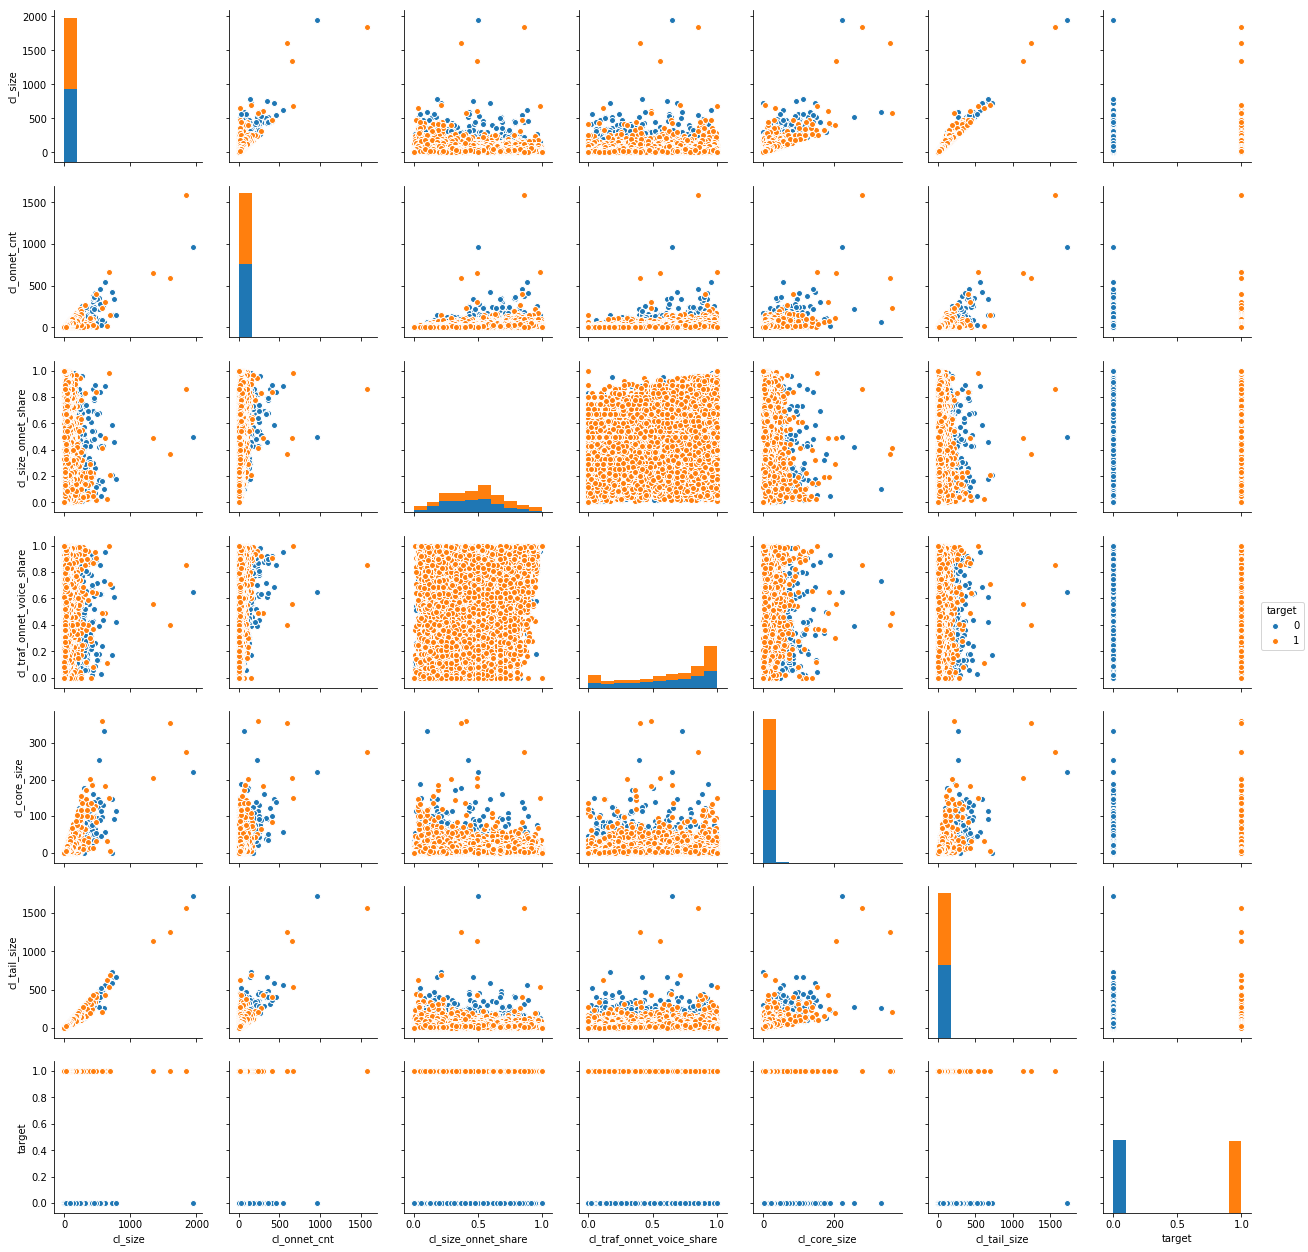

In [74]:
sns.pairplot(data[tmp_1 + ['target']], hue='target')

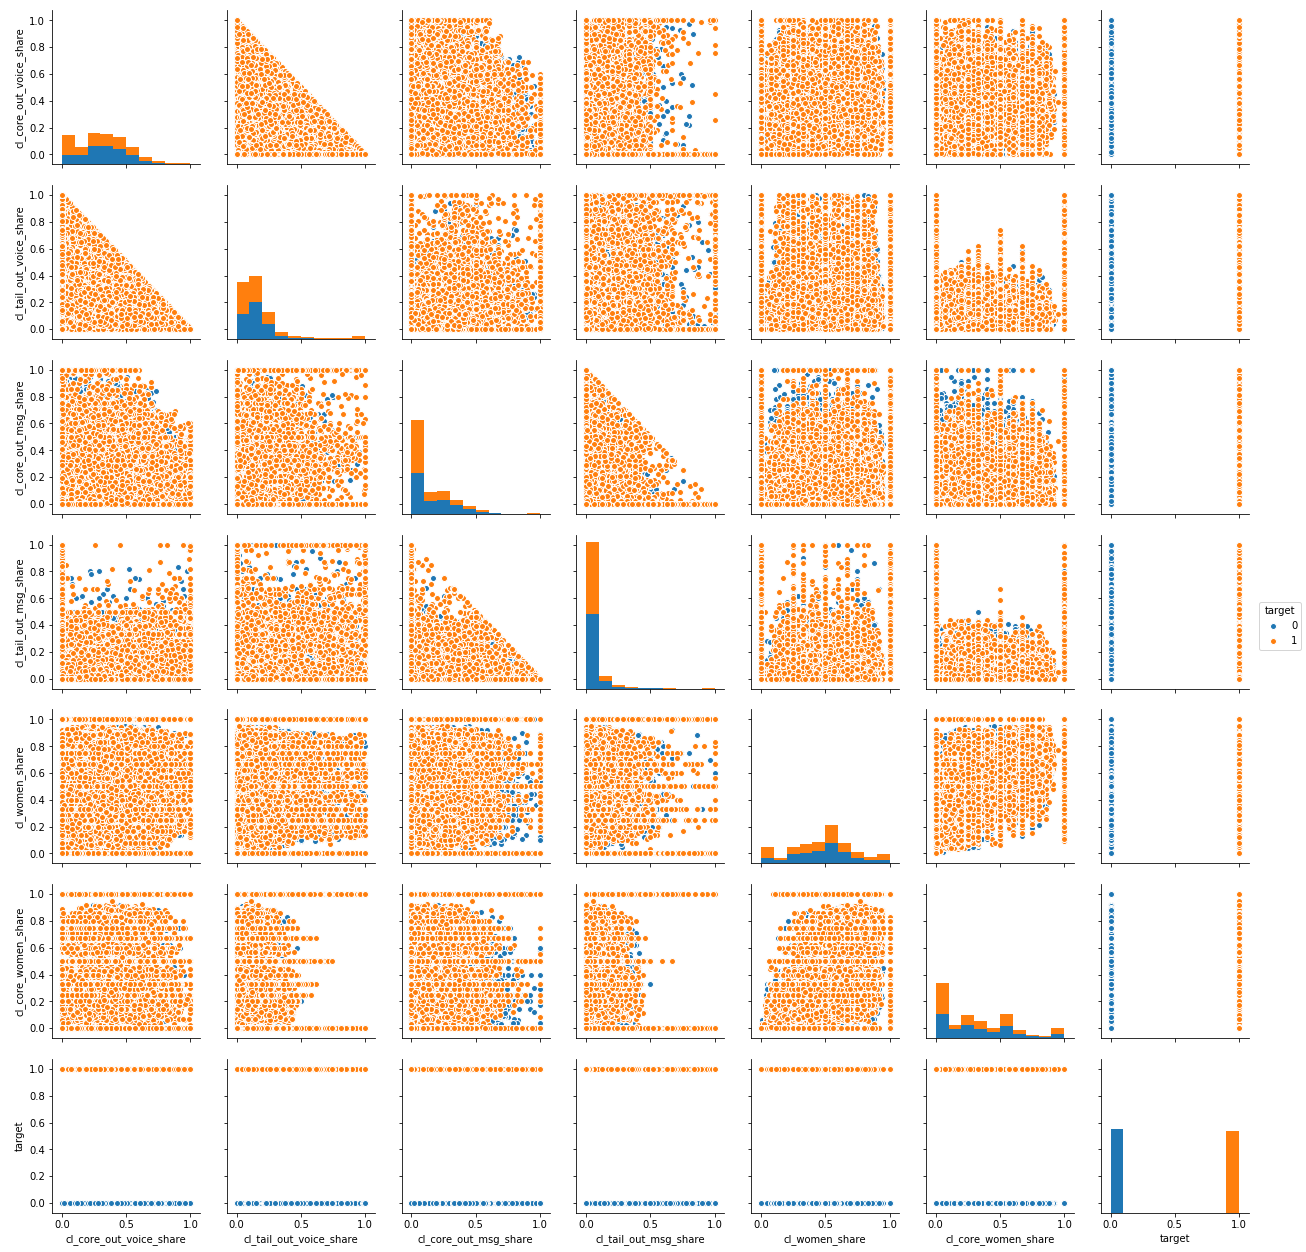

In [26]:
sns.pairplot(data[tmp_2 + ['target']], hue='target')

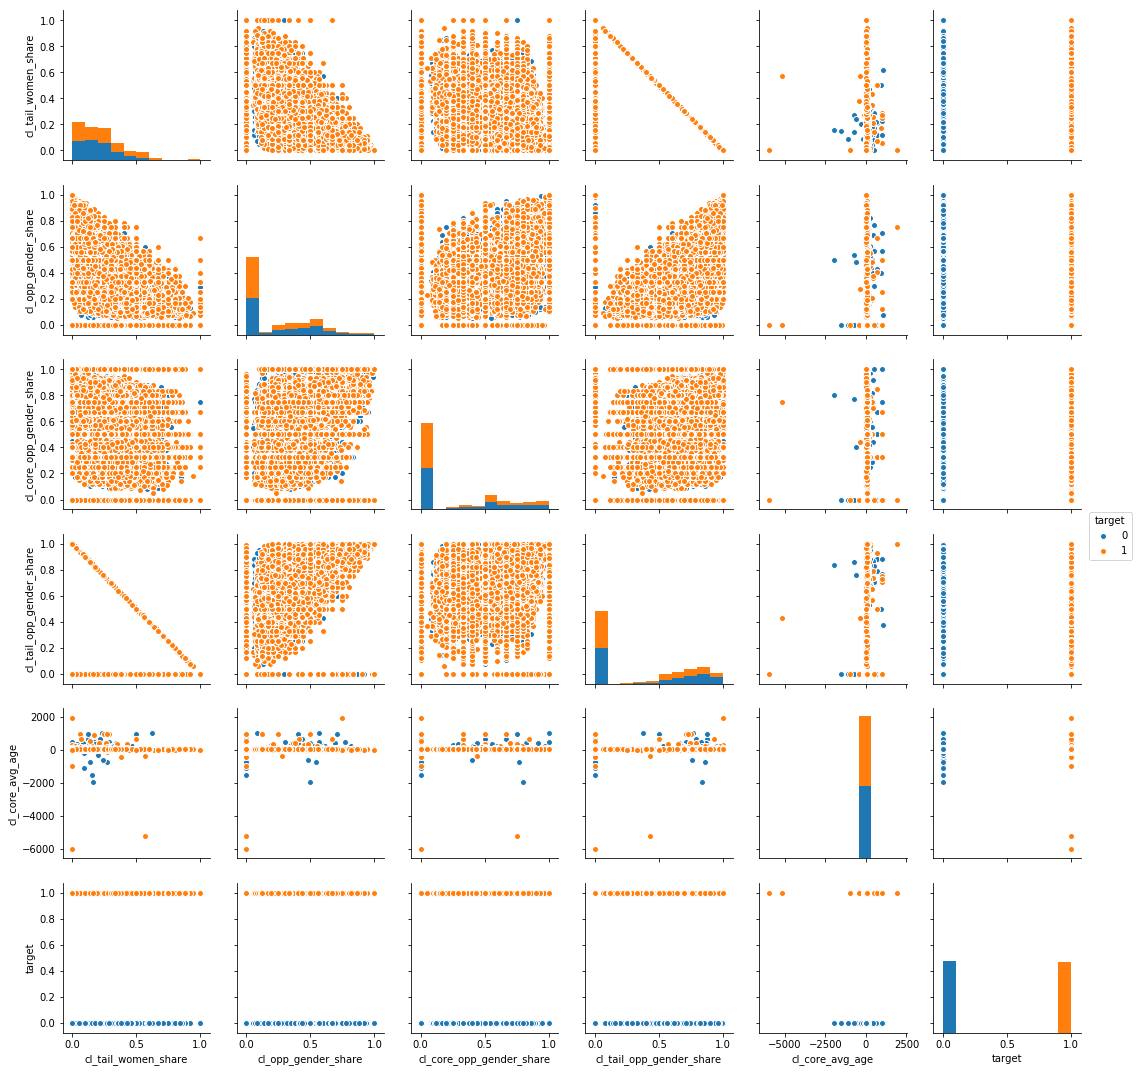

In [31]:
sns.pairplot(data[tmp_3 + ['target']], hue='target')

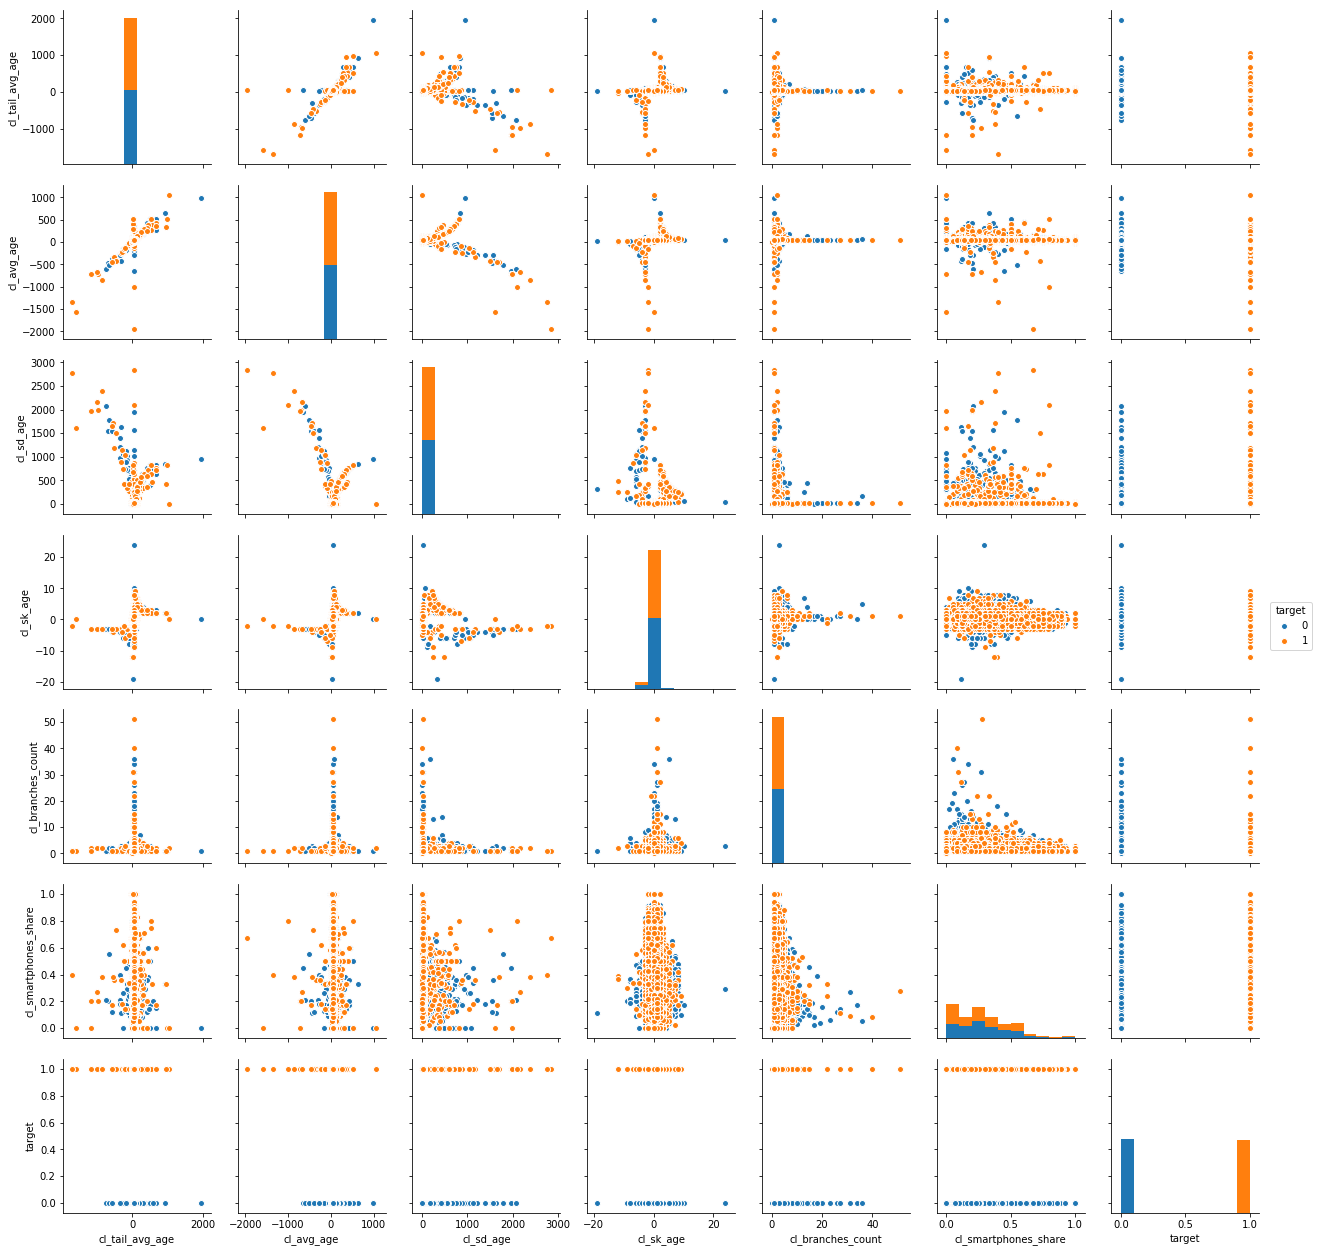

In [32]:
sns.pairplot(data[tmp_4 + ['target']], hue='target')

In [80]:
tmp = ['cv1', 'cv6']

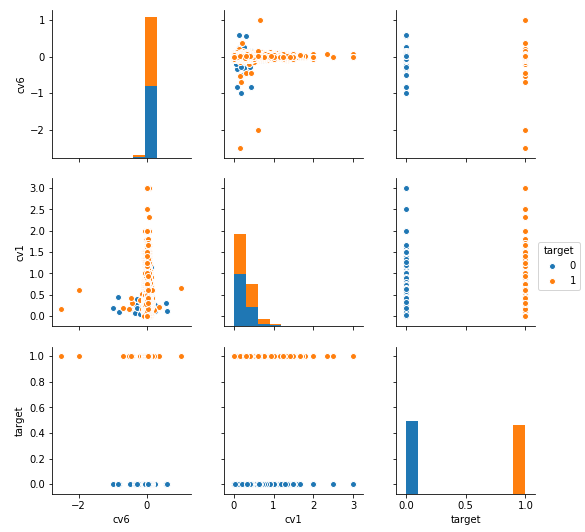

In [79]:
sns.pairplot(data[tmp + ['target']].dropna(), hue='target') 

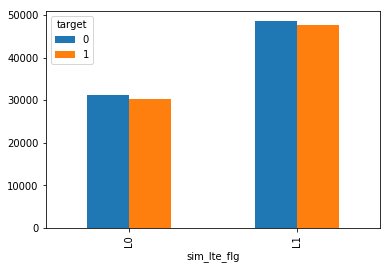

In [41]:
ct = pd.crosstab(data['sim_lte_flg'], data['target'])
ct.plot(kind='bar')

In [ ]:
tp_group, segm_id, macroregion, Archetype, still_first_tp

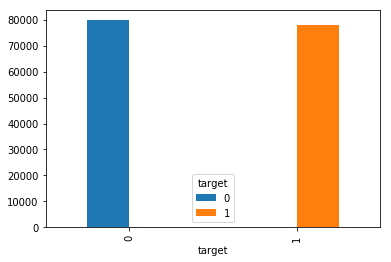

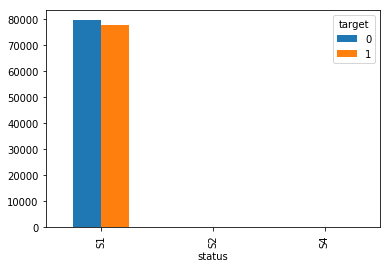

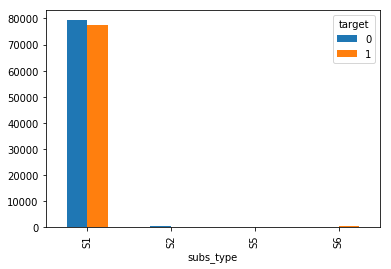

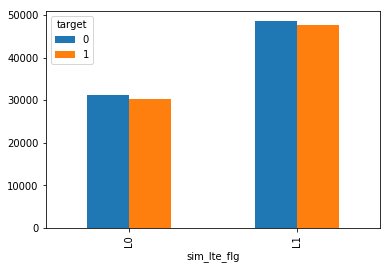

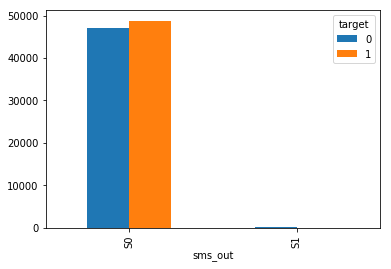

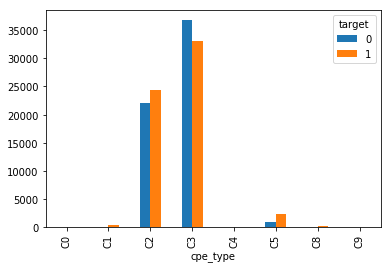

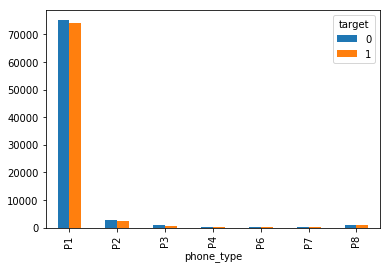

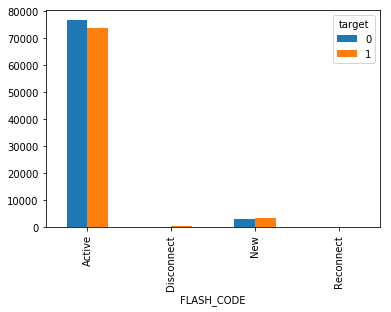

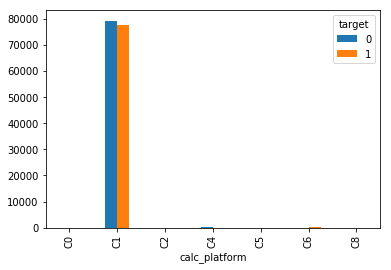

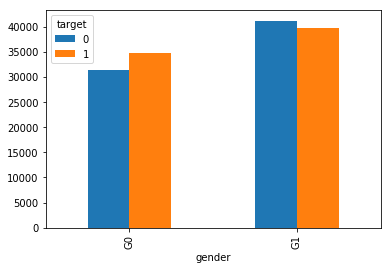

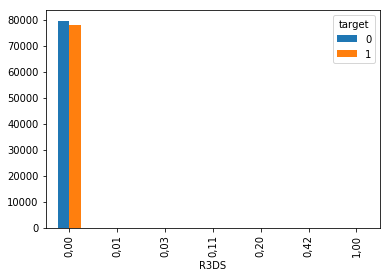

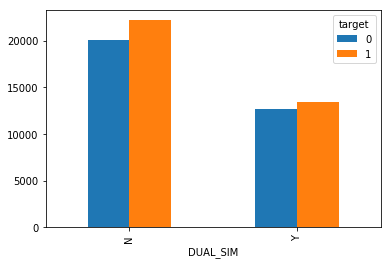

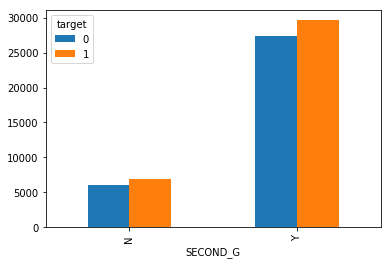

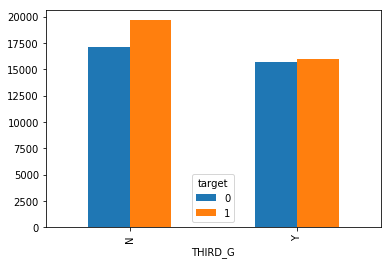

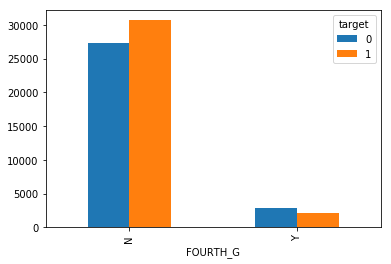

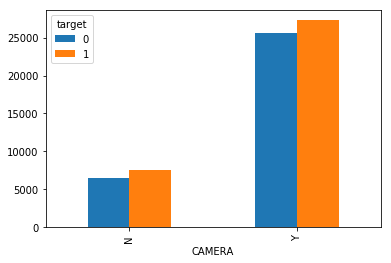

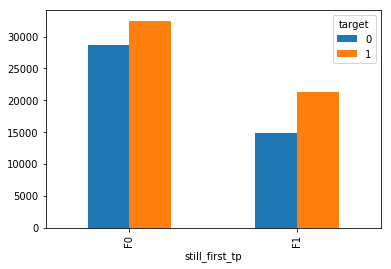

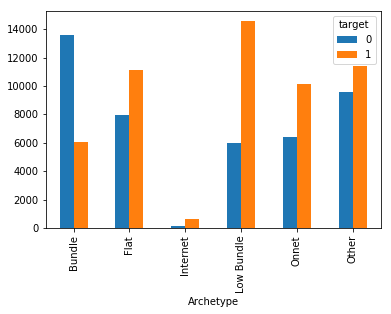

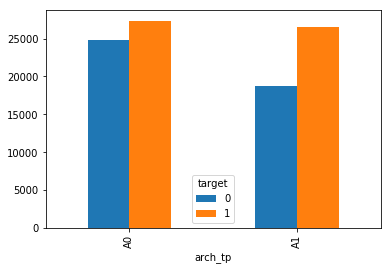

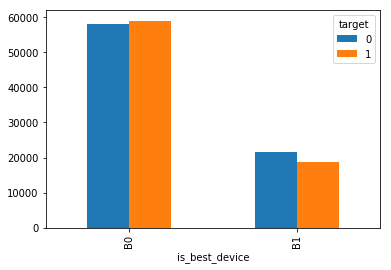

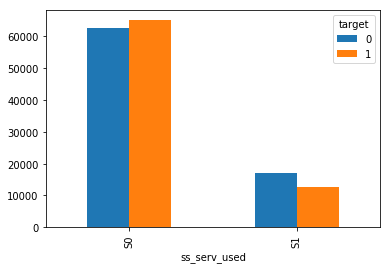

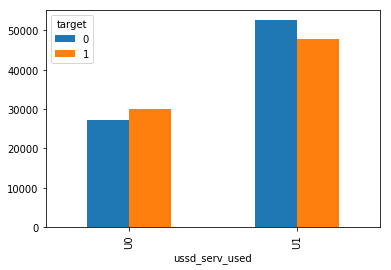

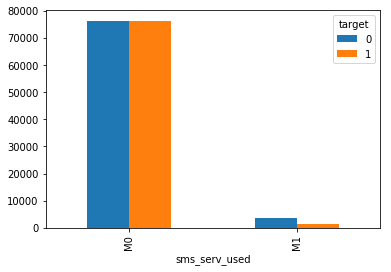

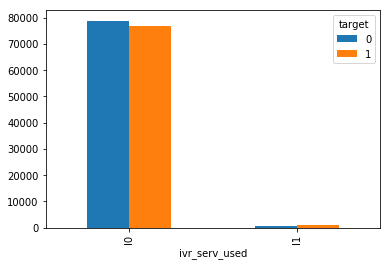

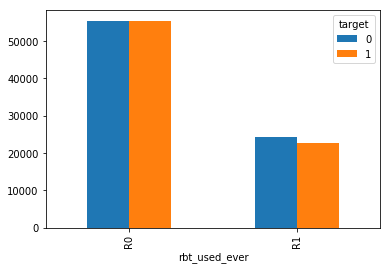

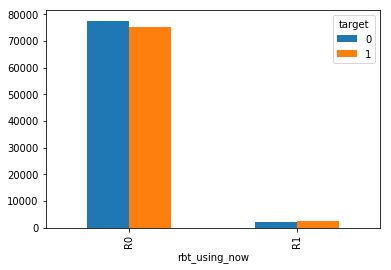

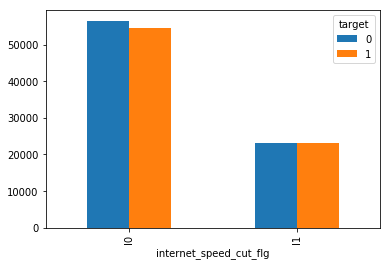

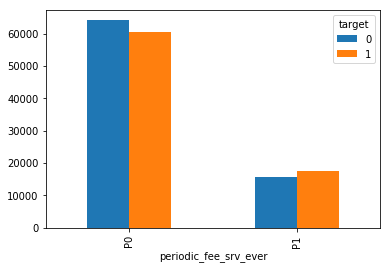

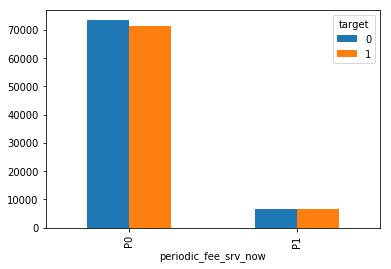

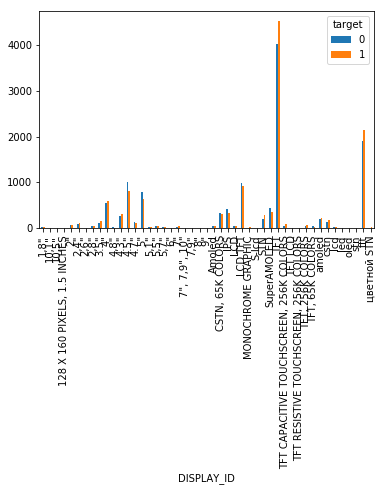

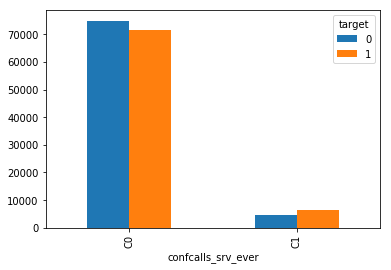

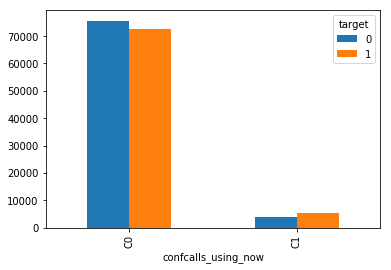

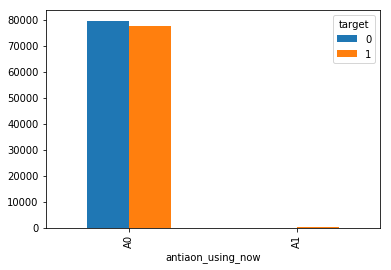

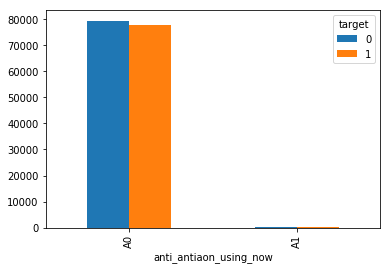

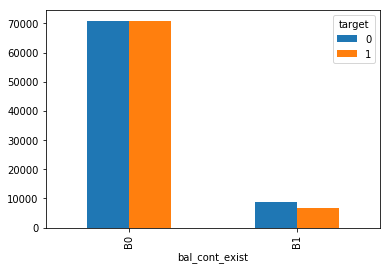

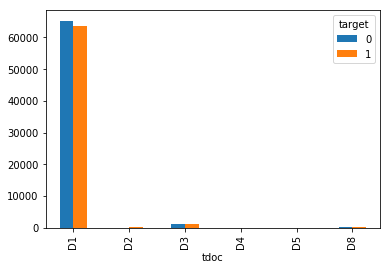

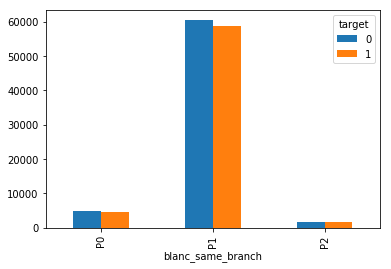

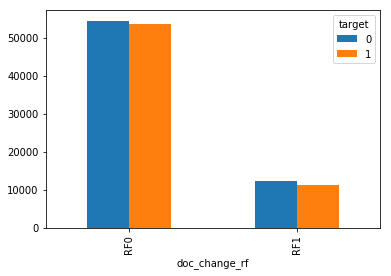

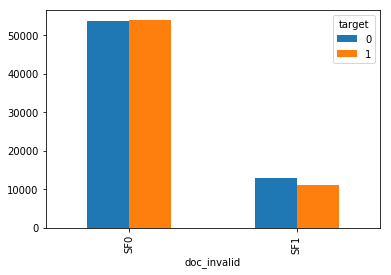

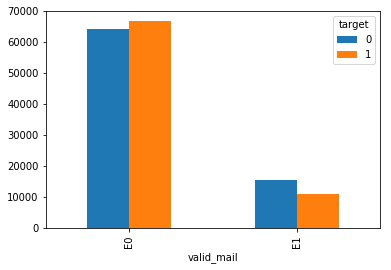

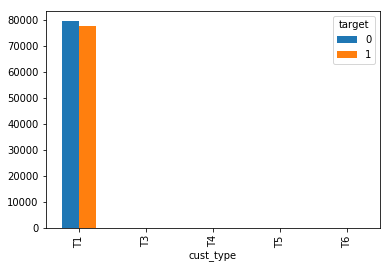

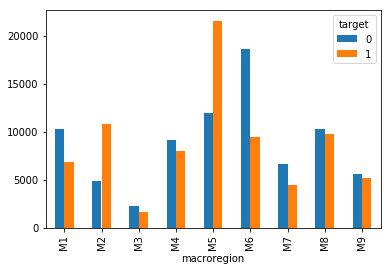

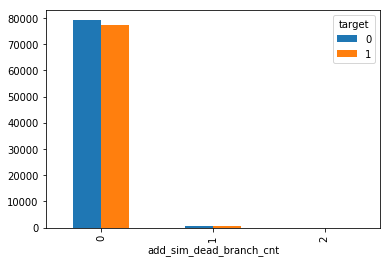

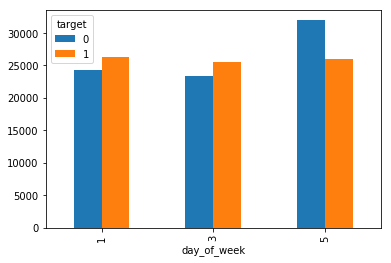

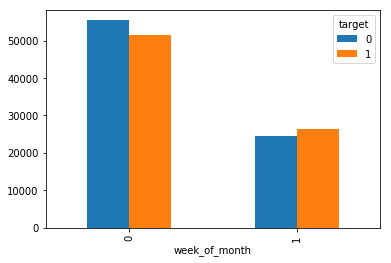

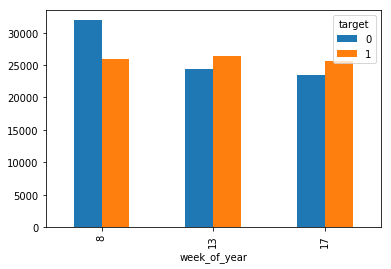

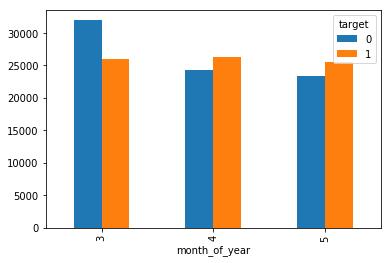

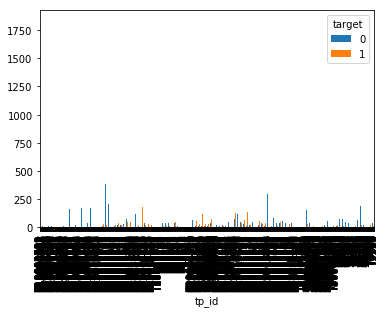

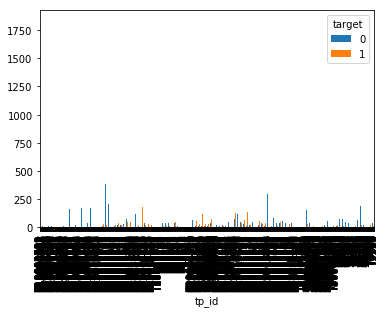

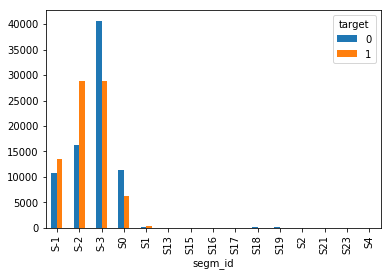

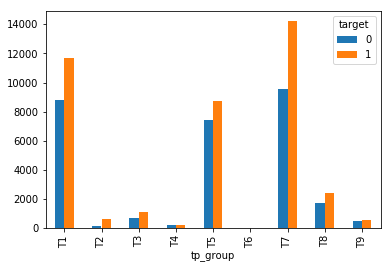

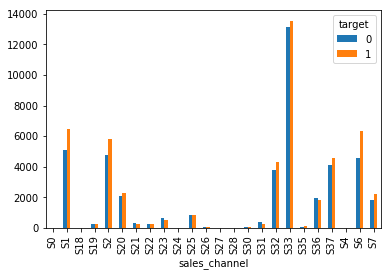

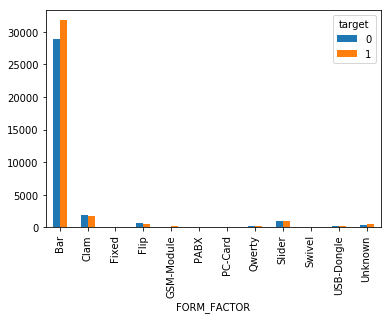

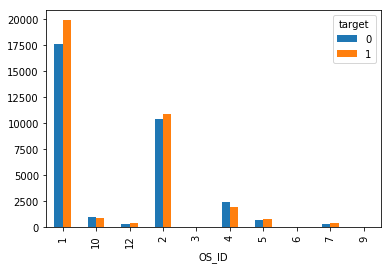

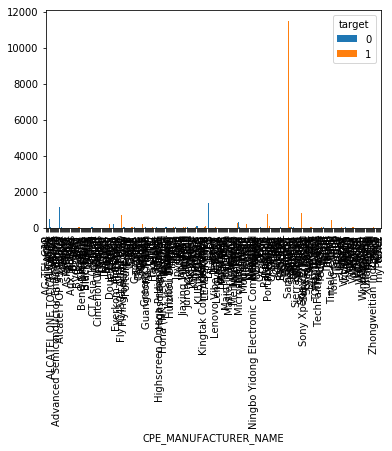

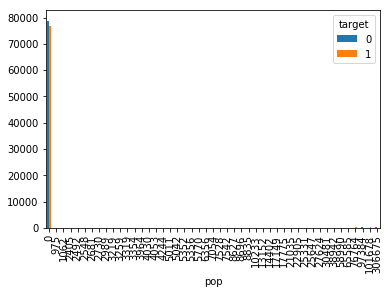

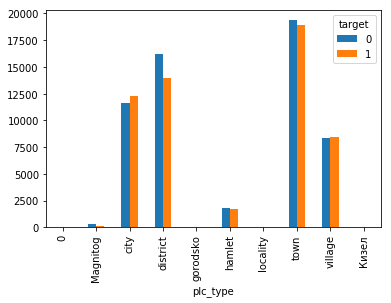

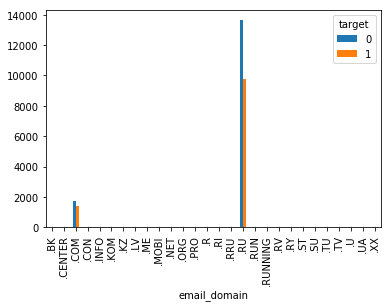

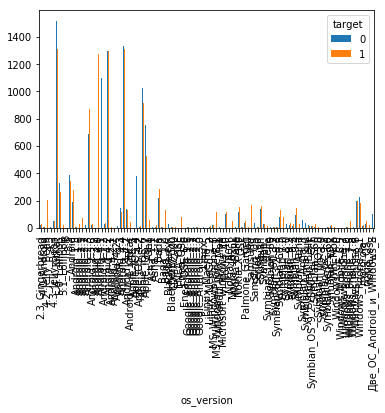

In [42]:
for i in feat_cat:
    ct = pd.crosstab(data[i], data['target'])
    ct.plot(kind='bar')

In [344]:
tmp_list = []
for i in ['tp_group', 'segm_id', 'macroregion', 'Archetype', 'still_first_tp', 'gender']:
    data = pd.concat([data,pd.get_dummies(data[i], prefix=i)],axis=1)
    tmp_list.append(i)

In [345]:
data = data.drop(tmp_list,axis=1)

In [346]:
data.shape

(157573, 290)

In [347]:
data.head()

,MSISDN,target,status,subs_type,lifetime,firstcall_delay,tp_id,sim_lte_flg,sms_out,cpe_type,...,Archetype_Bundle,Archetype_Flat,Archetype_Internet,Archetype_Low Bundle,Archetype_Onnet,Archetype_Other,still_first_tp_F0,still_first_tp_F1,gender_G0,gender_G1
0,79081910159,0,S1,S1,4438,0,T11503,L1,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
1,79535041164,0,S1,S1,3022,0,T20013506,L1,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,79514782745,0,S1,S1,3228,0,T10009470,L0,NaN,C3,...,1,0,0,0,0,0,1,0,0,1
3,79081993277,1,S1,S1,4385,0,T1957,L0,NaN,C2,...,0,1,0,0,0,0,1,0,0,1
4,79504428118,0,S1,S1,4510,0,T30001908,L1,S0,C3,...,0,0,0,0,0,0,0,0,0,0


In [348]:
new_feat_cat = []
for j in ['tp_group', 'segm_id', 'macroregion', 'Archetype', 'still_first_tp', 'gender']:
    for i in data.columns:
        if i.find(j) > -1:
            #print(i,j)
            new_feat_cat.append(i)

In [349]:
len(new_feat_cat)

46

In [350]:
data[new_feat_cat].head()

,tp_group_T1,tp_group_T2,tp_group_T3,tp_group_T4,tp_group_T5,tp_group_T6,tp_group_T7,tp_group_T8,tp_group_T9,segm_id_S-1,...,Archetype_Low Bundle,Archetype_Onnet,Archetype_Other,still_first_tp_F0,still_first_tp_F1,cl_opp_gender_share,cl_core_opp_gender_share,cl_tail_opp_gender_share,gender_G0,gender_G1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.00,0.00,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.00,0.00,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.5,0.67,0.84,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1.0,0.00,1.00,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.00,0.00,0,0


In [351]:
X = data[tmp_1+tmp_2+tmp_3+tmp_4+new_feat_cat]#.drop(['MSISDN', 'target'],axis=1)
Y = data['target'].astype(int)

In [352]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X.values, Y.values, test_size=0.3, random_state=5)
# fit model no training data
model = xgboost.XGBClassifier(random_state=1)
model.fit(X_train, y_train, eval_metric='auc')
# make predictions for test data
y_pred = model.predict(X_test)

In [353]:
roc_auc_score(y_test, y_pred)

0.7278399767094925

In [354]:
###

In [366]:
from sklearn.model_selection import GridSearchCV, cross_val_score
xgb_params = {"max_depth" : [2, 3],
              "learning_rate" : [0.01,0.05],
              'n_estimators':[150], 
              "gamma" : [3,1],  
              "subsample" : [1, 0.8, 0.7],
               'n_jobs' : [5]}

fit_params={
    "eval_set":[(X_test, y_test)],
    "eval_metric": 'auc',
    "early_stopping_rounds":100,
    "verbose":True
}

model = xgboost.XGBClassifier(random_state=1)

In [ ]:
%%time
clf = GridSearchCV(model, xgb_params, verbose=False,
                            scoring='roc_auc', cv=3,
                            fit_params=fit_params)
clf.fit(X_train, y_train)

[0]	validation_0-auc:0.69285
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.69285
[2]	validation_0-auc:0.69285
[3]	validation_0-auc:0.706815
[4]	validation_0-auc:0.706815
[5]	validation_0-auc:0.707527
[6]	validation_0-auc:0.707527
[7]	validation_0-auc:0.707366
[8]	validation_0-auc:0.711277
[9]	validation_0-auc:0.711062
[10]	validation_0-auc:0.712568
[11]	validation_0-auc:0.711582
[12]	validation_0-auc:0.711264
[13]	validation_0-auc:0.711688
[14]	validation_0-auc:0.71266
[15]	validation_0-auc:0.711688
[16]	validation_0-auc:0.71266
[17]	validation_0-auc:0.711688
[18]	validation_0-auc:0.71266
[19]	validation_0-auc:0.71266
[20]	validation_0-auc:0.71266
[21]	validation_0-auc:0.71266
[22]	validation_0-auc:0.712739
[23]	validation_0-auc:0.712762
[24]	validation_0-auc:0.711789
[25]	validation_0-auc:0.712761
[26]	validation_0-auc:0.712761
[27]	validation_0-auc:0.717443
[28]	validation_0-auc:0.717209
[29]	validation_0-auc:0.717456
[30]	validation_0-auc:0.

[110]	validation_0-auc:0.746564
[111]	validation_0-auc:0.7466
[112]	validation_0-auc:0.746628
[113]	validation_0-auc:0.746766
[114]	validation_0-auc:0.746795
[115]	validation_0-auc:0.746896
[116]	validation_0-auc:0.747077
[117]	validation_0-auc:0.747124
[118]	validation_0-auc:0.747204
[119]	validation_0-auc:0.747377
[120]	validation_0-auc:0.747611
[121]	validation_0-auc:0.747711
[122]	validation_0-auc:0.748107
[123]	validation_0-auc:0.74817
[124]	validation_0-auc:0.748272
[125]	validation_0-auc:0.748581
[126]	validation_0-auc:0.748619
[127]	validation_0-auc:0.749003
[128]	validation_0-auc:0.749034
[129]	validation_0-auc:0.749587
[130]	validation_0-auc:0.749708
[131]	validation_0-auc:0.750061
[132]	validation_0-auc:0.750121
[133]	validation_0-auc:0.750408
[134]	validation_0-auc:0.750504
[135]	validation_0-auc:0.750846
[136]	validation_0-auc:0.750943
[137]	validation_0-auc:0.751155
[138]	validation_0-auc:0.751531
[139]	validation_0-auc:0.751841
[140]	validation_0-auc:0.752201
[141]	valid

[69]	validation_0-auc:0.739315
[70]	validation_0-auc:0.73973
[71]	validation_0-auc:0.739688
[72]	validation_0-auc:0.739716
[73]	validation_0-auc:0.740077
[74]	validation_0-auc:0.740376
[75]	validation_0-auc:0.740483
[76]	validation_0-auc:0.7407
[77]	validation_0-auc:0.740748
[78]	validation_0-auc:0.741004
[79]	validation_0-auc:0.740917
[80]	validation_0-auc:0.740908
[81]	validation_0-auc:0.740835
[82]	validation_0-auc:0.740956
[83]	validation_0-auc:0.74112
[84]	validation_0-auc:0.741615
[85]	validation_0-auc:0.7419
[86]	validation_0-auc:0.74205
[87]	validation_0-auc:0.742282
[88]	validation_0-auc:0.742417
[89]	validation_0-auc:0.74249
[90]	validation_0-auc:0.742686
[91]	validation_0-auc:0.742765
[92]	validation_0-auc:0.742796
[93]	validation_0-auc:0.742688
[94]	validation_0-auc:0.742754
[95]	validation_0-auc:0.742981
[96]	validation_0-auc:0.743021
[97]	validation_0-auc:0.743168
[98]	validation_0-auc:0.743366
[99]	validation_0-auc:0.743271
[100]	validation_0-auc:0.743395
[101]	validatio

[28]	validation_0-auc:0.731221
[29]	validation_0-auc:0.73094
[30]	validation_0-auc:0.730827
[31]	validation_0-auc:0.730795
[32]	validation_0-auc:0.730834
[33]	validation_0-auc:0.730874
[34]	validation_0-auc:0.730869
[35]	validation_0-auc:0.730956
[36]	validation_0-auc:0.731051
[37]	validation_0-auc:0.731043
[38]	validation_0-auc:0.731043
[39]	validation_0-auc:0.731043
[40]	validation_0-auc:0.730957
[41]	validation_0-auc:0.731297
[42]	validation_0-auc:0.731444
[43]	validation_0-auc:0.731406
[44]	validation_0-auc:0.731648
[45]	validation_0-auc:0.731777
[46]	validation_0-auc:0.731717
[47]	validation_0-auc:0.731799
[48]	validation_0-auc:0.734085
[49]	validation_0-auc:0.73436
[50]	validation_0-auc:0.734341
[51]	validation_0-auc:0.734738
[52]	validation_0-auc:0.73512
[53]	validation_0-auc:0.735215
[54]	validation_0-auc:0.736047
[55]	validation_0-auc:0.736011
[56]	validation_0-auc:0.735993
[57]	validation_0-auc:0.737596
[58]	validation_0-auc:0.737673
[59]	validation_0-auc:0.738133
[60]	valida

[139]	validation_0-auc:0.750937
[140]	validation_0-auc:0.751348
[141]	validation_0-auc:0.751476
[142]	validation_0-auc:0.751563
[143]	validation_0-auc:0.751632
[144]	validation_0-auc:0.751933
[145]	validation_0-auc:0.752371
[146]	validation_0-auc:0.752492
[147]	validation_0-auc:0.752689
[148]	validation_0-auc:0.75273
[149]	validation_0-auc:0.752801
[0]	validation_0-auc:0.691728
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.693769
[2]	validation_0-auc:0.693769
[3]	validation_0-auc:0.693769
[4]	validation_0-auc:0.693769
[5]	validation_0-auc:0.712486
[6]	validation_0-auc:0.712486
[7]	validation_0-auc:0.714241
[8]	validation_0-auc:0.714241
[9]	validation_0-auc:0.712117
[10]	validation_0-auc:0.711923
[11]	validation_0-auc:0.712415
[12]	validation_0-auc:0.712415
[13]	validation_0-auc:0.714681
[14]	validation_0-auc:0.714679
[15]	validation_0-auc:0.714621
[16]	validation_0-auc:0.71464
[17]	validation_0-auc:0.716891
[18]	validation_0-auc:0.71684
[19]	va

[99]	validation_0-auc:0.745009
[100]	validation_0-auc:0.74503
[101]	validation_0-auc:0.74511
[102]	validation_0-auc:0.745186
[103]	validation_0-auc:0.745327
[104]	validation_0-auc:0.745279
[105]	validation_0-auc:0.745427
[106]	validation_0-auc:0.745431
[107]	validation_0-auc:0.745723
[108]	validation_0-auc:0.745788
[109]	validation_0-auc:0.745953
[110]	validation_0-auc:0.746131
[111]	validation_0-auc:0.746451
[112]	validation_0-auc:0.746521
[113]	validation_0-auc:0.746673
[114]	validation_0-auc:0.747022
[115]	validation_0-auc:0.747016
[116]	validation_0-auc:0.746911
[117]	validation_0-auc:0.747676
[118]	validation_0-auc:0.747634
[119]	validation_0-auc:0.747789
[120]	validation_0-auc:0.747798
[121]	validation_0-auc:0.747874
[122]	validation_0-auc:0.748261
[123]	validation_0-auc:0.748344
[124]	validation_0-auc:0.748468
[125]	validation_0-auc:0.748556
[126]	validation_0-auc:0.748718
[127]	validation_0-auc:0.749008
[128]	validation_0-auc:0.749357
[129]	validation_0-auc:0.749518
[130]	valid

[58]	validation_0-auc:0.75506
[59]	validation_0-auc:0.755186
[60]	validation_0-auc:0.755318
[61]	validation_0-auc:0.755403
[62]	validation_0-auc:0.755439
[63]	validation_0-auc:0.755843
[64]	validation_0-auc:0.756819
[65]	validation_0-auc:0.756809
[66]	validation_0-auc:0.756748
[67]	validation_0-auc:0.756994
[68]	validation_0-auc:0.757348
[69]	validation_0-auc:0.757474
[70]	validation_0-auc:0.757816
[71]	validation_0-auc:0.757909
[72]	validation_0-auc:0.757979
[73]	validation_0-auc:0.758192
[74]	validation_0-auc:0.757959
[75]	validation_0-auc:0.758129
[76]	validation_0-auc:0.758172
[77]	validation_0-auc:0.758357
[78]	validation_0-auc:0.758435
[79]	validation_0-auc:0.758647
[80]	validation_0-auc:0.758676
[81]	validation_0-auc:0.758732
[82]	validation_0-auc:0.758779
[83]	validation_0-auc:0.758831
[84]	validation_0-auc:0.75894
[85]	validation_0-auc:0.759175
[86]	validation_0-auc:0.75932
[87]	validation_0-auc:0.759295
[88]	validation_0-auc:0.759562
[89]	validation_0-auc:0.759756
[90]	valida

[17]	validation_0-auc:0.748396
[18]	validation_0-auc:0.748214
[19]	validation_0-auc:0.748217
[20]	validation_0-auc:0.748429
[21]	validation_0-auc:0.748498
[22]	validation_0-auc:0.749202
[23]	validation_0-auc:0.749332
[24]	validation_0-auc:0.750593
[25]	validation_0-auc:0.750755
[26]	validation_0-auc:0.750915
[27]	validation_0-auc:0.750897
[28]	validation_0-auc:0.751194
[29]	validation_0-auc:0.751808
[30]	validation_0-auc:0.752299
[31]	validation_0-auc:0.752125
[32]	validation_0-auc:0.752465
[33]	validation_0-auc:0.752658
[34]	validation_0-auc:0.752598
[35]	validation_0-auc:0.752617
[36]	validation_0-auc:0.752845
[37]	validation_0-auc:0.752941
[38]	validation_0-auc:0.753065
[39]	validation_0-auc:0.753294
[40]	validation_0-auc:0.75355
[41]	validation_0-auc:0.753586
[42]	validation_0-auc:0.753701
[43]	validation_0-auc:0.753805
[44]	validation_0-auc:0.753828
[45]	validation_0-auc:0.753904
[46]	validation_0-auc:0.755055
[47]	validation_0-auc:0.755183
[48]	validation_0-auc:0.755435
[49]	vali

In [ ]:
print('Best score', clf.best_score_ )
print('Best params',clf.best_params_)

In [ ]:
# Prediction performance on test set is not as good as on train set
clf.score(X_test, y_test)

In [368]:
#gridsearch.get_params().keys()

In [356]:
from sklearn.model_selection import ShuffleSplit
model = xgboost.XGBClassifier(random_state=1,learning_rate=0.05, n_estimators=150, 
                              n_jobs=5, gamma=3, subsample=0.7, max_depth= 3)

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

In [357]:
#cross_val = cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc')
model.fit(X_test, y_test, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=5, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [363]:
cross_val = cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc')
cross_val

array([0.79599731, 0.80150829, 0.79625031])

In [364]:
# predict
y_pred = model.predict(X_test)

In [365]:
roc_auc_score(y_test, y_pred)

0.7293291952657162

In [362]:
# Значимость признаков
df = pd.DataFrame() 
df['col_name'] = X.columns
df['importance'] = model.feature_importances_
df = df.sort_values(by=['importance'], ascending=False)
df.head(10)

,col_name,importance
5,cl_tail_size,0.120229
58,Archetype_Bundle,0.049618
9,cl_tail_out_voice_share,0.048664
53,macroregion_M5,0.045802
64,still_first_tp_F0,0.043893
8,cl_core_out_voice_share,0.042939
10,cl_core_out_msg_share,0.041985
20,cl_avg_age,0.039122
6,cv1,0.038168
61,Archetype_Low Bundle,0.036260
